# Find burger-menu on image via YOLOv7

In [9]:
# detection parameters. can be changed according to input data.
conf_threshold_1 = 0.04
conf_threshold_2 = 0.1
nms_threshold = 0.2
max_detections = 10
image_size = 640 # MUST be 640 or 1280. impacts speed and accuracy. was trained on 640.

In [2]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from yolov7 import create_yolov7_model
from yolov7.dataset import Yolov7Dataset, create_yolov7_transforms
from yolov7.trainer import filter_eval_predictions
from yolov7.models.yolo import scale_bboxes_to_original_image_size
import time
import cv2
import math

INFO:pytorch_accelerated:Setting random seeds


In [3]:
print(torch.cuda.is_available())

True


In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class BurgerDatasetAdaptor(Dataset):
    def __init__(
        self,
        images_dir_path,
        annotations_dataframe,
        transforms=None,
    ):
        self.images_dir_path = images_dir_path
        self.annotations_df = annotations_dataframe
        self.transforms = transforms

        self.image_idx_to_image_id = {
            idx: image_id
            for idx, image_id in enumerate(self.annotations_df.image_id.unique())
        }
        self.image_id_to_image_idx = {
            v: k for k, v, in self.image_idx_to_image_id.items()
        }

    def __len__(self) -> int:
        return len(self.image_idx_to_image_id)

    def __getitem__(self, index):
        image_id = self.image_idx_to_image_id[index]
        image_info = self.annotations_df[self.annotations_df.image_id == image_id]
        file_name = image_info.image.values[0]
        assert image_id == image_info.image_id.values[0]

        image = Image.open(os.path.join(self.images_dir_path, file_name)).convert("RGB")
        image = np.array(image)

        image_hw = image.shape[:2]

        if image_info.has_annotation.any():
            xyxy_bboxes = image_info[["xmin", "ymin", "xmax", "ymax"]].values
            class_ids = image_info["class_id"].values
        else:
            xyxy_bboxes = np.array([])
            class_ids = np.array([])

        if self.transforms is not None:
            transformed = self.transforms(
                image=image, bboxes=xyxy_bboxes, labels=class_ids
            )
            image = transformed["image"]
            xyxy_bboxes = np.array(transformed["bboxes"])
            class_ids = np.array(transformed["labels"])

        return image, xyxy_bboxes, class_ids, image_id, image_hw

model = create_yolov7_model('yolov7', num_classes=1, pretrained=False)
model.load_state_dict(torch.load("burger.pt", map_location=device))

<All keys matched successfully>

In [6]:
root_dir = os.getcwd()
jpg_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
jpg_files

input_df = pd.DataFrame({
    'image_id': range(len(jpg_files)),
    'has_annotation': False,
    'image': jpg_files
})
input_df

,image_id,has_annotation,image
0,0,False,photo_2023-05-13_12-23-19.jpg
1,1,False,photo_2023-05-13_14-25-04 (2).jpg
2,2,False,photo_2023-05-13_14-25-04 (3).jpg
3,3,False,photo_2023-05-13_14-25-04.jpg


In [7]:
# draw a single bounding box onto a numpy array image
def draw_bounding_box(img, annotation):
    if not annotation.any() :
        return
    x_min, y_min = int(annotation[0]), int(annotation[1])
    x_max, y_max = int(annotation[2]), int(annotation[3])
    color = (255,0,0)
    cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)

# draw all annotation bounding boxes on an image
def annotate_image(img, boxes):
    for box in boxes:
        draw_bounding_box(img, box)

Labeling: 100%|██████████| 4/4 [00:00<00:00,  6.79image/s]


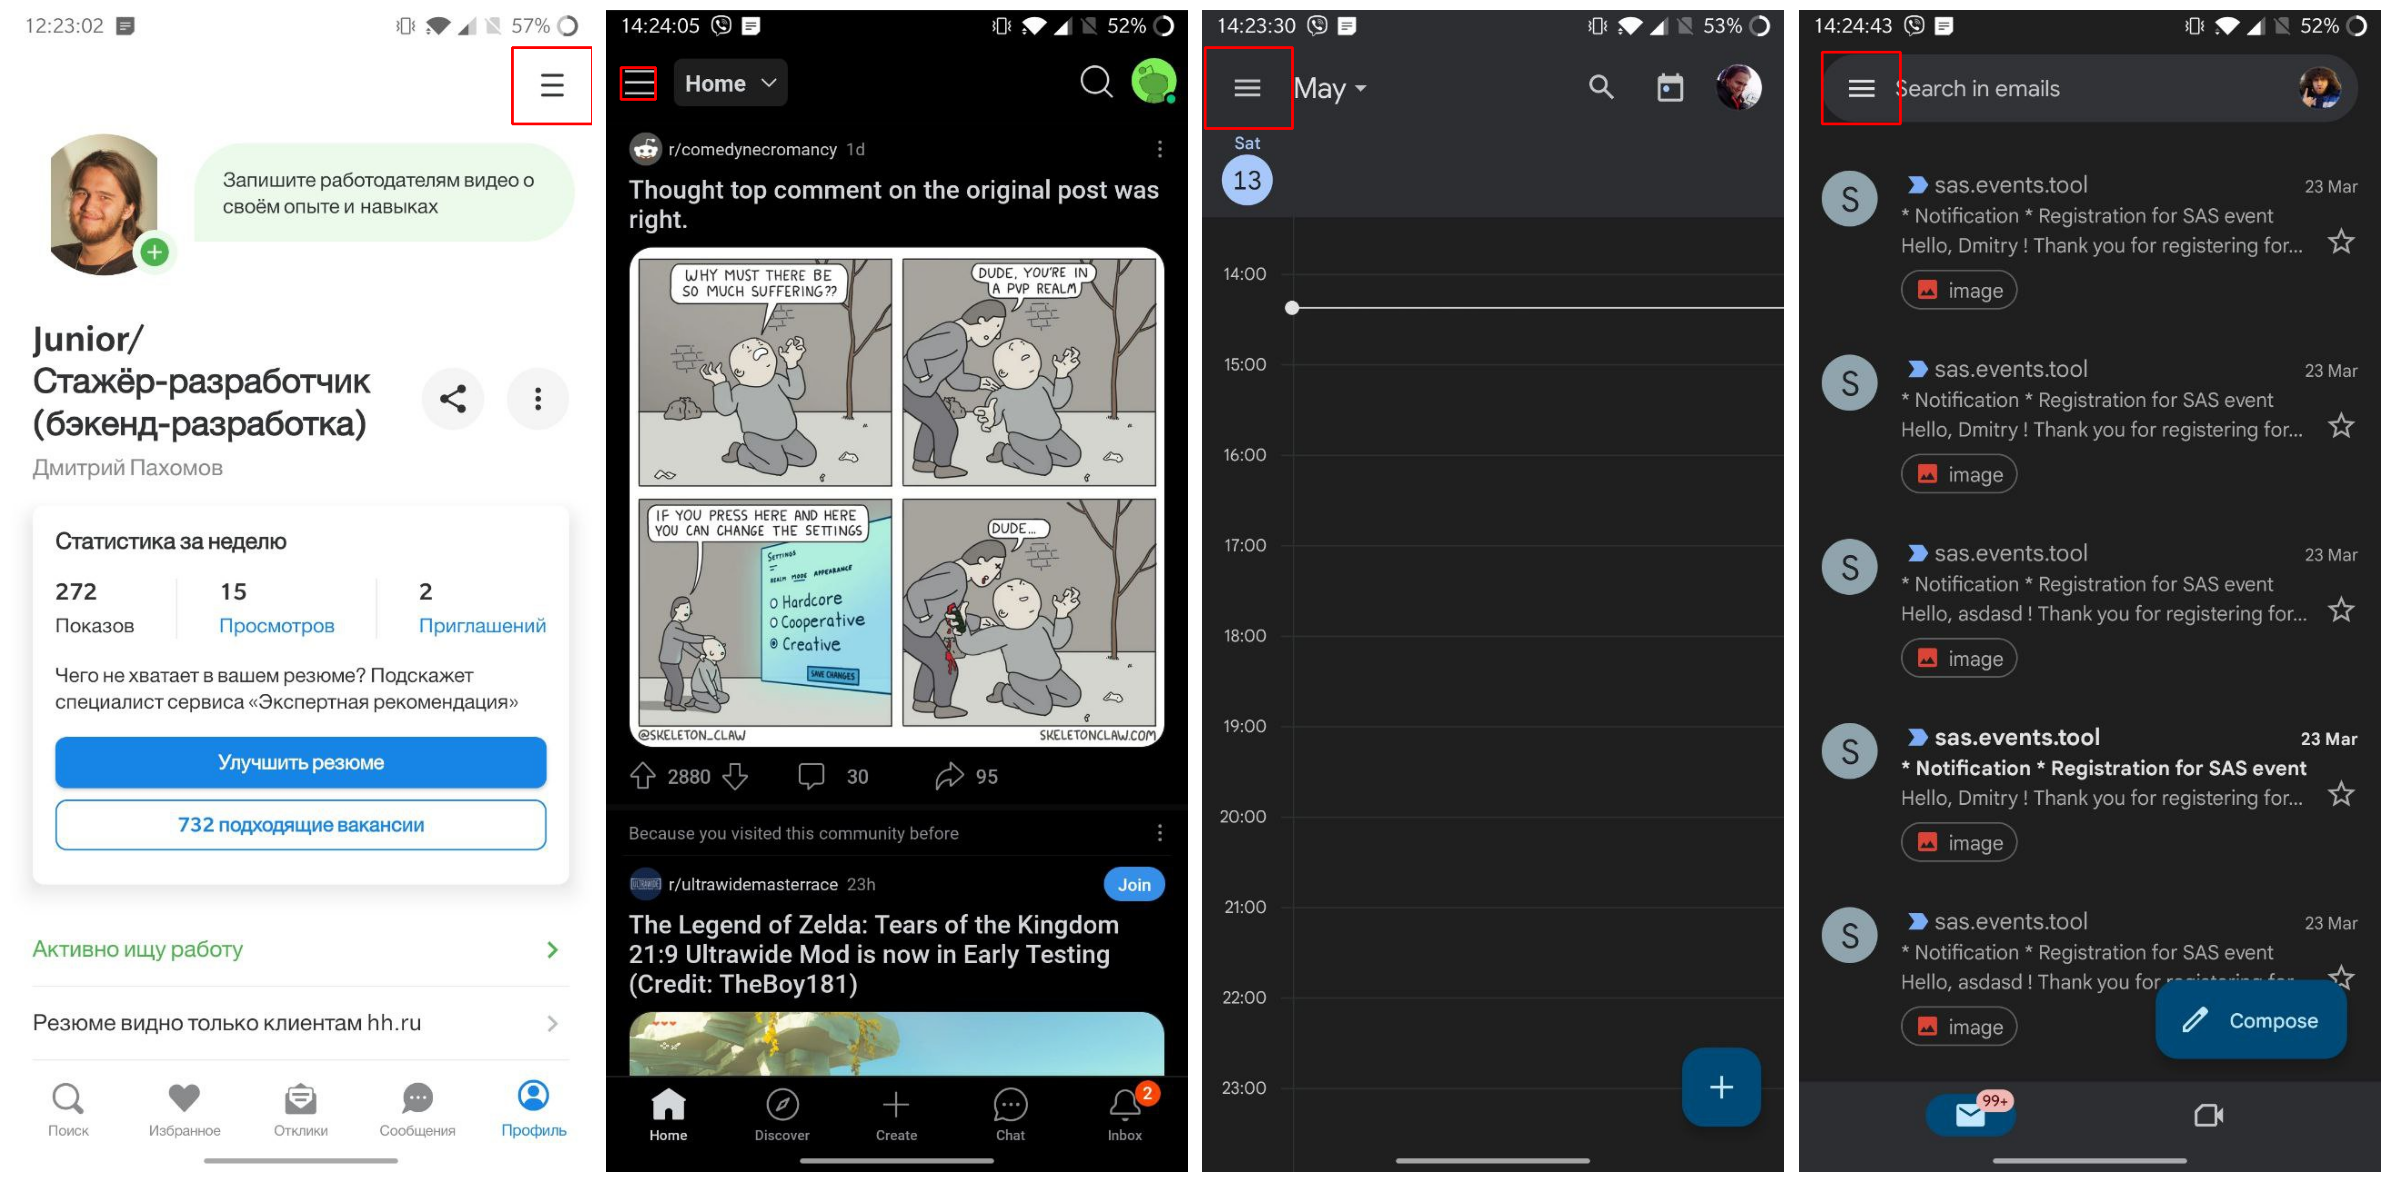

Time taken: 593.75 ms


In [16]:
model.to(device)
input_ds = BurgerDatasetAdaptor(root_dir, input_df)
yolo_ds = Yolov7Dataset(input_ds, transforms=create_yolov7_transforms(image_size=(image_size, image_size)))
pred_loader = DataLoader(yolo_ds, batch_size=1)
id_boxes = {}

# timing the detections
start = time.time()
model.eval()
with torch.no_grad():
    for i, (image, label, id, shape) in enumerate(tqdm(pred_loader, total=len(pred_loader), unit='image', desc=f"Labeling")):
        image = image.to(device)
        outputs = model(image)
        preds = model.postprocess(outputs, conf_thres=conf_threshold_1, max_detections=max_detections)
        output = filter_eval_predictions(preds, confidence_threshold=conf_threshold_2, nms_threshold=nms_threshold)
        boxes = output[0][:, :4]
        boxes = scale_bboxes_to_original_image_size(boxes, (image_size, image_size), shape[0])
        id_boxes[i] = boxes
end = time.time()

num_rows = int(math.ceil(len(id_boxes) / 4))
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 12*num_rows))
for i, ax in enumerate(axes.flat):
    if i < len(id_boxes):
        image = np.array(Image.open(input_df.iloc[i]['image']).convert("RGB"))
        annotate_image(image, id_boxes[i])
        ax.imshow(image)
        ax.axis('off')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()
print(f"Time taken: {(end - start) * 1000:.2f} ms")